In [1]:
# Opsional – aman di-skip jika sudah ada
import sys, subprocess, importlib
def pip_try(*pkgs):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])
        print("✅", " ".join(pkgs))
    except Exception as e:
        print("⚠️  skip", " ".join(pkgs), "->", e)

pip_try("pandas", "numpy", "scikit-learn", "matplotlib", "joblib", "scipy")
import sklearn, numpy, pandas, scipy
print("Python:", sys.executable)
print("sklearn:", sklearn.__version__)


✅ pandas numpy scikit-learn matplotlib joblib scipy
Python: c:\Users\hamas\AppData\Local\Programs\Python\Python313\python.exe
sklearn: 1.7.1


### Import

In [2]:
import os, re, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import scipy.sparse as sp
import joblib

try:
    from IPython.display import display
except Exception:
    pass


### RuleFit-Lite: rules dari RandomForest + L1 Logistic Regression

In [3]:
class RuleFitLite:
    def __init__(self, n_estimators=200, max_depth=5, min_samples_leaf=1,
                 random_state=42, alpha=1.0):
        self.rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
        )
        # C = 1/alpha
        self.alpha = float(alpha)
        self.lr = LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0/max(self.alpha, 1e-8),
            max_iter=3000,
            multi_class="auto",
        )
        self.classes_ = None

    def _rules_matrix(self, X):
        mats = []
        for est in self.rf.estimators_:
            M = est.decision_path(X)
            if M.shape[1] > 1:
                M = M[:, 1:]
            mats.append(M)
        if len(mats) == 1:
            return mats[0].tocsr()
        return sp.hstack(mats, format="csr")

    def fit(self, X, y):
        X = np.asarray(X)
        self.rf.fit(X, y)
        self.classes_ = np.unique(y)
        R = self._rules_matrix(X)
        self.lr.fit(R, y)
        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        R = self._rules_matrix(X)
        return self.lr.predict_proba(R)

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = probs.argmax(axis=1)
        return np.array([self.lr.classes_[i] for i in idx])


### Data

In [4]:
DATA_PATH = "./dataset.csv"

TARGET_COL = "Role"

if DATA_PATH is None:
    csvs = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if len(csvs) == 1:
        DATA_PATH = csvs[0]
        print(f"Auto-detected dataset: {DATA_PATH}")
    elif len(csvs) > 1:
        picks = [f for f in csvs if re.search(r'career|map|skill|job|role', f, re.I)]
        if picks:
            DATA_PATH = picks[0]
            print(f"Auto-detected dataset (heuristic): {DATA_PATH}")
        else:
            print("Multiple CSV ditemukan. Set DATA_PATH manual.")
    else:
        print("Tidak ada file .csv. Set DATA_PATH manual.")

if DATA_PATH is None:
    raise FileNotFoundError("Set DATA_PATH ke file dataset kamu (CSV/XLSX).")

if DATA_PATH.lower().endswith('.csv'):
    df = pd.read_csv(DATA_PATH)
elif DATA_PATH.lower().endswith(('.xlsx', '.xls')):
    df = pd.read_excel(DATA_PATH)

print("Shape:", df.shape)
try: display(df.head())
except: print(df.head())


Shape: (9179, 28)


,Database Fundamentals,Computer Architecture,Distributed Computing Systems,Cyber Security,Networking,Software Development,Programming Skills,Project Management,Computer Forensics Fundamentals,Technical Communication,...,Conscientousness,Extraversion,Agreeableness,Emotional_Range,Conversation,Openness to Change,Hedonism,Self-enhancement,Self-transcendence,Role
0,6,4,4,4,4,4,4,4,4,4,...,0.480564,0.470877,0.039611,0.742567,0.086927,0.339776,0.091158,0.230518,0.208746,Database Administrator
1,6,5,4,4,4,4,4,4,4,4,...,0.452903,0.377581,0.090148,0.672546,0.071425,0.353678,0.104495,0.247432,0.196424,Database Administrator
2,6,1,4,4,4,4,4,4,4,4,...,0.461668,0.347739,0.138575,0.630705,0.095261,0.375125,0.135462,0.287253,0.268024,Database Administrator
3,6,0,4,4,4,4,4,4,4,4,...,0.521783,0.403756,0.114925,0.695280,0.122656,0.338899,0.161705,0.306562,0.258119,Database Administrator
4,6,3,4,4,4,4,4,4,4,4,...,0.319539,0.240337,0.050988,0.619390,0.065564,0.311896,0.147700,0.302978,0.207287,Database Administrator


### deteksi target, tipe fitur, preprocessing

In [5]:
if TARGET_COL is None:
    candidates = [c for c in df.columns if re.search(r'(job|role|position|pekerjaan|label|target)', c, re.I)]
    TARGET_COL = candidates[0] if candidates else df.columns[-1]
print("Target column:", TARGET_COL)

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]
print("Numerik:", num_cols[:10], "..." if len(num_cols)>10 else "")
print("Kategorikal:", cat_cols[:10], "..." if len(cat_cols)>10 else "")

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])
feature_columns = list(X.columns)


Target column: Role
Numerik: ['Database Fundamentals', 'Computer Architecture', 'Distributed Computing Systems', 'Cyber Security', 'Networking', 'Software Development', 'Programming Skills', 'Project Management', 'Computer Forensics Fundamentals', 'Technical Communication'] ...
Kategorikal: [] 


In [6]:
def analyze_and_bin_numeric_columns(df, numeric_cols):
    """
    Analisis range setiap kolom numerik dan buat binning ke 1-5
    """
    binning_info = {}
    
    for col in numeric_cols:
        # Skip jika kolom sudah dalam range 1-5
        col_data = df[col].dropna()
        if len(col_data) == 0:
            continue
            
        min_val = col_data.min()
        max_val = col_data.max()
        
        print(f"\n{col}:")
        print(f"  Range: [{min_val:.2f}, {max_val:.2f}]")
        print(f"  Mean: {col_data.mean():.2f}, Median: {col_data.median():.2f}")
        
        # Jika sudah dalam range 1-5, skip binning
        if min_val >= 1 and max_val <= 5 and col_data.nunique() <= 5:
            print(f"  ✓ Sudah dalam range 1-5, skip binning")
            binning_info[col] = None
            continue
        
        # Buat bins menggunakan quantile untuk distribusi yang lebih merata
        bins = [-np.inf]
        for q in [0.2, 0.4, 0.6, 0.8]:
            bins.append(col_data.quantile(q))
        bins.append(np.inf)
        
        # Hapus duplikat bins
        bins = sorted(list(set(bins)))
        
        labels = list(range(1, len(bins)))
        binning_info[col] = {'bins': bins, 'labels': labels}
        
        print(f"  → Bins: {[f'{b:.2f}' for b in bins]}")
        print(f"  → Labels: {labels}")
    
    return binning_info

# Analisis dan buat binning info
print("="*60)
print("ANALISIS KOLOM NUMERIK UNTUK BINNING")
print("="*60)
binning_info = analyze_and_bin_numeric_columns(X, num_cols)

ANALISIS KOLOM NUMERIK UNTUK BINNING

Database Fundamentals:
  Range: [0.00, 6.00]
  Mean: 2.71, Median: 3.00
  → Bins: ['-inf', '1.00', '2.00', '3.00', '5.00', 'inf']
  → Labels: [1, 2, 3, 4, 5]

Computer Architecture:
  Range: [0.00, 6.00]
  Mean: 2.71, Median: 3.00
  → Bins: ['-inf', '1.00', '2.00', '3.00', '5.00', 'inf']
  → Labels: [1, 2, 3, 4, 5]

Distributed Computing Systems:
  Range: [0.00, 6.00]
  Mean: 2.71, Median: 3.00
  → Bins: ['-inf', '1.00', '2.00', '3.00', '5.00', 'inf']
  → Labels: [1, 2, 3, 4, 5]

Cyber Security:
  Range: [0.00, 6.00]
  Mean: 2.71, Median: 3.00
  → Bins: ['-inf', '1.00', '2.00', '3.00', '5.00', 'inf']
  → Labels: [1, 2, 3, 4, 5]

Networking:
  Range: [0.00, 6.00]
  Mean: 2.71, Median: 3.00
  → Bins: ['-inf', '1.00', '2.00', '3.00', '5.00', 'inf']
  → Labels: [1, 2, 3, 4, 5]

Software Development:
  Range: [0.00, 6.00]
  Mean: 2.71, Median: 3.00
  → Bins: ['-inf', '1.00', '2.00', '3.00', '5.00', 'inf']
  → Labels: [1, 2, 3, 4, 5]

Programming Skills:

In [7]:
def apply_binning(X, binning_info):
    """
    Terapkan binning ke dataframe
    """
    X_binned = X.copy()
    
    for col, info in binning_info.items():
        if info is None:  # Skip jika sudah dalam range
            continue
            
        bins = info['bins']
        labels = info['labels']
        
        # Gunakan pd.cut untuk binning
        X_binned[col] = pd.cut(
            X[col], 
            bins=bins, 
            labels=labels, 
            include_lowest=True,
            duplicates='drop'
        )
        
        # Convert ke numeric
        X_binned[col] = pd.to_numeric(X_binned[col], errors='coerce')
    
    return X_binned

# Terapkan binning ke X
X_binned = apply_binning(X, binning_info)

# Verifikasi hasil binning
print("\n" + "="*60)
print("HASIL BINNING")
print("="*60)
for col in num_cols:
    if binning_info.get(col) is not None:
        print(f"\n{col}:")
        print(f"  Range baru: [{X_binned[col].min():.0f}, {X_binned[col].max():.0f}]")
        print(f"  Distribusi: \n{X_binned[col].value_counts().sort_index()}")

# Update X dengan hasil binning
X = X_binned

print("\n✅ Binning selesai! Semua kolom numerik sekarang dalam range 1-5")


HASIL BINNING

Database Fundamentals:
  Range baru: [1, 5]
  Distribusi: 
Database Fundamentals
1    2880
2    1439
3    1440
4    2880
5     540
Name: count, dtype: int64

Computer Architecture:
  Range baru: [1, 5]
  Distribusi: 
Computer Architecture
1    2880
2    1439
3    1440
4    2880
5     540
Name: count, dtype: int64

Distributed Computing Systems:
  Range baru: [1, 5]
  Distribusi: 
Distributed Computing Systems
1    2880
2    1439
3    1440
4    2880
5     540
Name: count, dtype: int64

Cyber Security:
  Range baru: [1, 5]
  Distribusi: 
Cyber Security
1    2880
2    1439
3    1440
4    2880
5     540
Name: count, dtype: int64

Networking:
  Range baru: [1, 5]
  Distribusi: 
Networking
1    2880
2    1439
3    1440
4    2880
5     540
Name: count, dtype: int64

Software Development:
  Range baru: [1, 5]
  Distribusi: 
Software Development
1    2880
2    1439
3    1440
4    2880
5     540
Name: count, dtype: int64

Programming Skills:
  Range baru: [1, 5]
  Distribusi: 
Pr

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique()>1 else None
)
print("Train:", X_train.shape, "Val:", X_val.shape)

# Tampilkan sample data setelah binning
print("\nSample data setelah binning:")
display(X_train.head())

Train: (7343, 27) Val: (1836, 27)

Sample data setelah binning:


,Database Fundamentals,Computer Architecture,Distributed Computing Systems,Cyber Security,Networking,Software Development,Programming Skills,Project Management,Computer Forensics Fundamentals,Technical Communication,...,Openness,Conscientousness,Extraversion,Agreeableness,Emotional_Range,Conversation,Openness to Change,Hedonism,Self-enhancement,Self-transcendence
5619,4,1,4,4,4,4,4,4,4,4,...,5,3,4,3,2,1,4,1,3,1
1735,4,4,4,5,4,4,4,4,4,4,...,4,2,3,2,3,1,1,3,1,1
4567,2,2,2,2,2,2,2,2,5,2,...,4,5,5,5,5,3,2,1,1,1
2914,2,2,2,2,2,5,2,2,2,2,...,3,1,2,3,2,4,3,4,2,4
8627,1,1,1,1,1,1,1,1,1,1,...,1,4,3,4,4,5,2,4,3,5


### Decission Tree

In [9]:
dt_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ))
])
dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_val)

acc_dt = accuracy_score(y_val, y_pred_dt)
f1w_dt = f1_score(y_val, y_pred_dt, average="weighted")
f1m_dt = f1_score(y_val, y_pred_dt, average="macro")

print(f"DT -> acc={acc_dt:.4f}, f1_weighted={f1w_dt:.4f}, f1_macro={f1m_dt:.4f}")
print("\nClassification report (DT):\n", classification_report(y_val, y_pred_dt))


DT -> acc=1.0000, f1_weighted=1.0000, f1_macro=1.0000

Classification report (DT):
                                  precision    recall  f1-score   support

               AI ML Specialist       1.00      1.00      1.00       216
                 API Specialist       1.00      1.00      1.00       108
   Application Support Engineer       1.00      1.00      1.00       108
               Business Analyst       1.00      1.00      1.00       108
     Customer Service Executive       1.00      1.00      1.00       108
      Cyber Security Specialist       1.00      1.00      1.00       108
         Database Administrator       1.00      1.00      1.00       108
              Graphics Designer       1.00      1.00      1.00       108
              Hardware Engineer       1.00      1.00      1.00       108
              Helpdesk Engineer       1.00      1.00      1.00       108
Information Security Specialist       1.00      1.00      1.00       108
            Networking Engineer       1

### Rule Fit

In [10]:
# Fit preprocess -> array DENSE
pre_X_train = preprocess.fit_transform(X_train)
pre_X_val   = preprocess.transform(X_val)

rf_lite = RuleFitLite(
    n_estimators=300,   # lebih banyak pohon -> lebih banyak rules
    max_depth=5,       # kedalaman rules
    min_samples_leaf=1,
    random_state=42,
    alpha=1.0          # regulasi L1 (lebih besar -> lebih sedikit rules aktif)
)
rf_lite.fit(pre_X_train, y_train)

# Prediksi
y_pred_rf = rf_lite.predict(pre_X_val)

acc_rf = accuracy_score(y_val, y_pred_rf)
f1w_rf = f1_score(y_val, y_pred_rf, average="weighted")
f1m_rf = f1_score(y_val, y_pred_rf, average="macro")

print(f"RuleFit-Lite -> acc={acc_rf:.4f}, f1_weighted={f1w_rf:.4f}, f1_macro={f1m_rf:.4f}")
print("\nClassification report (RuleFit-Lite):\n", classification_report(y_val, y_pred_rf))


RuleFit-Lite -> acc=1.0000, f1_weighted=1.0000, f1_macro=1.0000

Classification report (RuleFit-Lite):
                                  precision    recall  f1-score   support

               AI ML Specialist       1.00      1.00      1.00       216
                 API Specialist       1.00      1.00      1.00       108
   Application Support Engineer       1.00      1.00      1.00       108
               Business Analyst       1.00      1.00      1.00       108
     Customer Service Executive       1.00      1.00      1.00       108
      Cyber Security Specialist       1.00      1.00      1.00       108
         Database Administrator       1.00      1.00      1.00       108
              Graphics Designer       1.00      1.00      1.00       108
              Hardware Engineer       1.00      1.00      1.00       108
              Helpdesk Engineer       1.00      1.00      1.00       108
Information Security Specialist       1.00      1.00      1.00       108
            Network

### Perbandingan

In [11]:
metrics = pd.DataFrame({
    "model": ["DecisionTree", "RuleFit-Lite"],
    "acc":   [acc_dt, acc_rf],
    "f1_weighted": [f1w_dt, f1w_rf],
    "f1_macro":    [f1m_dt, f1m_rf]
})
display(metrics.sort_values("f1_macro", ascending=False))

best_name = metrics.sort_values("f1_macro", ascending=False).iloc[0]["model"]
print("Best model by f1_macro:", best_name)

best_model = dt_pipe if best_name == "DecisionTree" else rf_lite


,model,acc,f1_weighted,f1_macro
0,DecisionTree,1.0,1.0,1.0
1,RuleFit-Lite,1.0,1.0,1.0


Best model by f1_macro: DecisionTree


### prediksi dari input skill user

In [12]:
def _ensure_columns(input_dict: Dict[str, Any], columns: List[str]) -> pd.DataFrame:
    return pd.DataFrame([{c: input_dict.get(c, np.nan) for c in columns}])

def predict_job(input_skills: Dict[str, Any], use_model: str = "best") -> Dict[str, Any]:
    """
    use_model: "dt", "rulefit", atau "best"
    """
    if use_model == "best":
        use_model = "dt" if best_name == "DecisionTree" else "rulefit"

    if use_model == "dt":
        X_in = _ensure_columns(input_skills, feature_columns)
        y_hat = dt_pipe.predict(X_in)[0]
        try:
            proba = dt_pipe.predict_proba(X_in)[0]
            classes = dt_pipe.classes_
        except Exception:
            proba, classes = None, None
    else:
        X_in_raw = _ensure_columns(input_skills, feature_columns)
        X_in_pre = preprocess.transform(X_in_raw)  # DENSE
        y_hat = rf_lite.predict(X_in_pre)[0]
        try:
            proba = rf_lite.predict_proba(X_in_pre)[0]
            classes = rf_lite.lr.classes_
        except Exception:
            proba, classes = None, None

    out = {"prediction": str(y_hat)}
    if proba is not None and classes is not None:
        order = np.argsort(proba)[::-1]
        out["topk"] = [(str(classes[i]), float(proba[i])) for i in order[:5]]
    return out

# Contoh cepat (isi median/modus)
example = {}
for c in feature_columns:
    if c in X.select_dtypes(include=[np.number]).columns:
        example[c] = float(np.nanmedian(pd.to_numeric(X[c], errors="coerce").values))
    else:
        try:
            example[c] = X[c].mode(dropna=True).iloc[0]
        except:
            example[c] = None

print("Contoh subset:", {k: example[k] for k in list(example)[:min(8, len(example))]}, "...")
print("Prediksi (best):", predict_job(example, use_model="best"))


Contoh subset: {'Database Fundamentals': 3.0, 'Computer Architecture': 3.0, 'Distributed Computing Systems': 3.0, 'Cyber Security': 3.0, 'Networking': 3.0, 'Software Development': 3.0, 'Programming Skills': 3.0, 'Project Management': 3.0} ...
Prediksi (best): {'prediction': 'AI ML Specialist', 'topk': [('AI ML Specialist', 1.0), ('Technical Writer', 0.0), ('Software Developer', 0.0), ('Software tester', 0.0), ('Networking Engineer', 0.0)]}


### Confusion Matrix

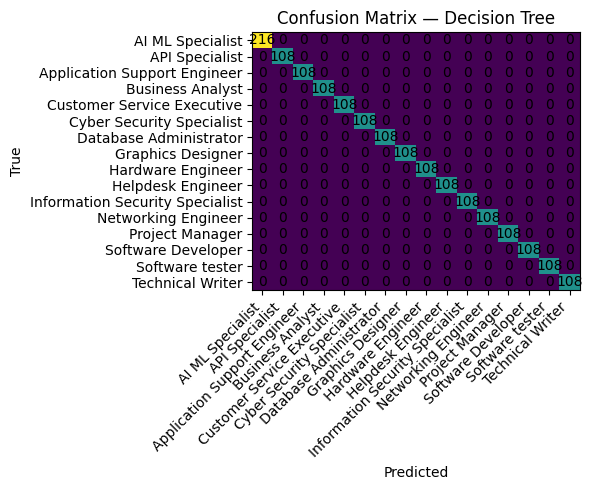

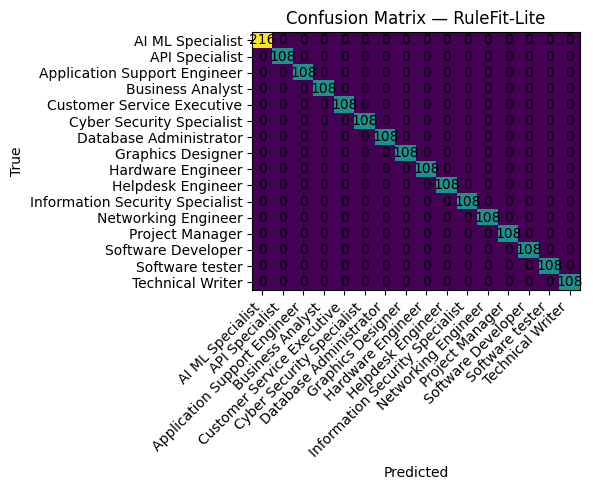

In [13]:
def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    labels = np.unique(np.concatenate([np.unique(y_true), np.unique(y_pred)]))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(cm, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()

plot_cm(y_val, y_pred_dt, title="Confusion Matrix — Decision Tree")
plot_cm(y_val, y_pred_rf, title="Confusion Matrix — RuleFit-Lite")


### simpan model

In [14]:
SAVE_DIR = "artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# Simpan Decision Tree (pipeline lengkap)
dt_path = os.path.join(SAVE_DIR, "job_predictor_dt_normalized.pth")
joblib.dump(dt_pipe, dt_path)

# Simpan RuleFit-Lite + preprocess
rf_path = os.path.join(SAVE_DIR, "job_predictor_rulefit_normalized.pth")   # nama disamakan
preprocess_path = os.path.join(SAVE_DIR, "preprocess_normalized.pth")
joblib.dump(rf_lite, rf_path)
joblib.dump(preprocess, preprocess_path)

# Simpan 'best' pointer + kolom fitur mentah
best_path = os.path.join(SAVE_DIR, "best_model_name.json")
with open(best_path, "w", encoding="utf-8") as f:
    json.dump({"best_model": str(best_name)}, f, ensure_ascii=False, indent=2)

featcol_path = os.path.join(SAVE_DIR, "feature_columns.json")
with open(featcol_path, "w", encoding="utf-8") as f:
    json.dump(feature_columns, f, ensure_ascii=False, indent=2)
    
binning_path = os.path.join(SAVE_DIR, "binning_info.json")
binning_serializable = {}
for col, info in binning_info.items():
    if info is None:
        binning_serializable[col] = None
    else:
        binning_serializable[col] = {
            'bins': [float(b) for b in info['bins']],
            'labels': [int(l) for l in info['labels']]
        }

with open(binning_path, "w", encoding="utf-8") as f:
    json.dump(binning_serializable, f, ensure_ascii=False, indent=2)


print("Tersimpan:")
print(" -", dt_path)
print(" -", rf_path)
print(" -", preprocess_path)
print(" -", best_path)
print(" -", featcol_path)
print(" -", binning_path)


Tersimpan:
 - artifacts\job_predictor_dt_normalized.pth
 - artifacts\job_predictor_rulefit_normalized.pth
 - artifacts\preprocess_normalized.pth
 - artifacts\best_model_name.json
 - artifacts\feature_columns.json
 - artifacts\binning_info.json


In [15]:
# Simpan hasil normalization ke CSV
normalize_output_path = "normalize.csv"

# Gabungkan X_binned dengan y (target) untuk output lengkap
X_normalized_with_target = X_binned.copy()
X_normalized_with_target[TARGET_COL] = y

# Simpan ke CSV
X_normalized_with_target.to_csv(normalize_output_path, index=False)

print("\n" + "="*60)
print("EXPORT HASIL NORMALIZATION")
print("="*60)
print(f"✅ Data hasil normalization disimpan ke: {normalize_output_path}")
print(f"   Total rows: {len(X_normalized_with_target)}")
print(f"   Total columns: {len(X_normalized_with_target.columns)}")
print(f"\nPreview 5 baris pertama:")
display(X_normalized_with_target.head())

# Verifikasi range kolom numerik
print(f"\nRange nilai setelah normalization:")
for col in num_cols:
    if col in X_normalized_with_target.columns:
        print(f"  {col}: [{X_normalized_with_target[col].min():.0f}, {X_normalized_with_target[col].max():.0f}]")


EXPORT HASIL NORMALIZATION
✅ Data hasil normalization disimpan ke: normalize.csv
   Total rows: 9179
   Total columns: 28

Preview 5 baris pertama:


,Database Fundamentals,Computer Architecture,Distributed Computing Systems,Cyber Security,Networking,Software Development,Programming Skills,Project Management,Computer Forensics Fundamentals,Technical Communication,...,Conscientousness,Extraversion,Agreeableness,Emotional_Range,Conversation,Openness to Change,Hedonism,Self-enhancement,Self-transcendence,Role
0,5,4,4,4,4,4,4,4,4,4,...,4,4,1,5,3,2,1,1,2,Database Administrator
1,5,4,4,4,4,4,4,4,4,4,...,3,3,2,4,2,2,1,1,2,Database Administrator
2,5,1,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,2,2,4,Database Administrator
3,5,1,4,4,4,4,4,4,4,4,...,4,3,3,5,4,2,3,3,4,Database Administrator
4,5,3,4,4,4,4,4,4,4,4,...,1,1,1,3,2,1,3,3,2,Database Administrator



Range nilai setelah normalization:
  Database Fundamentals: [1, 5]
  Computer Architecture: [1, 5]
  Distributed Computing Systems: [1, 5]
  Cyber Security: [1, 5]
  Networking: [1, 5]
  Software Development: [1, 5]
  Programming Skills: [1, 5]
  Project Management: [1, 5]
  Computer Forensics Fundamentals: [1, 5]
  Technical Communication: [1, 5]
  AI ML: [1, 5]
  Software Engineering: [1, 5]
  Business Analysis: [1, 5]
  Communication skills: [1, 5]
  Data Science: [1, 5]
  Troubleshooting skills: [1, 5]
  Graphics Designing: [1, 5]
  Openness: [1, 5]
  Conscientousness: [1, 5]
  Extraversion: [1, 5]
  Agreeableness: [1, 5]
  Emotional_Range: [1, 5]
  Conversation: [1, 5]
  Openness to Change: [1, 5]
  Hedonism: [1, 5]
  Self-enhancement: [1, 5]
  Self-transcendence: [1, 5]
